## Ebola infected Macaque Sample Composition Trajectory Identification

```
Indices:

- c cell type
- g genes
- m samples
- k deformation polynomial degree
```

In [1]:
import torch
import seaborn as sns

from time_deconv.time_deconv import *

## Parameter Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Train Base Model

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
type(pseudo_time_reg_deconv.dataset.bulk_raw_gex_mg)

torch.Tensor

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=5_000, verbose=True, log_frequency=1000)

[iteration: 0]   loss: 30370793.59
[iteration: 1000]   loss: 8745531.38
[iteration: 2000]   loss: 3653424.10
[iteration: 3000]   loss: 2126810.81
[iteration: 4000]   loss: 1545716.96


## Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

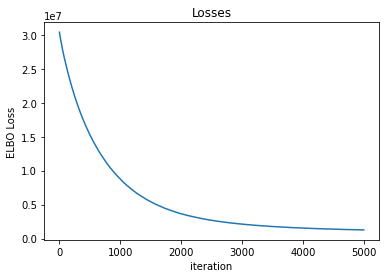

In [10]:
pseudo_time_reg_deconv.plot_loss()

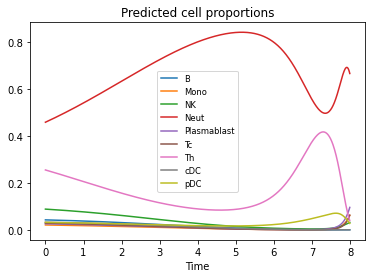

In [11]:
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

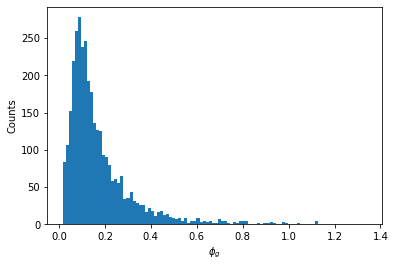

In [12]:
pseudo_time_reg_deconv.plot_phi_g_distribution()

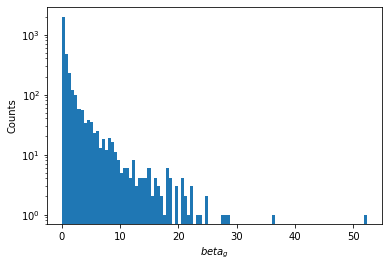

In [13]:
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Synthetic Data

In [14]:
def generate_evaluation_params(
    vary_param = ('deconvolution_params', 'polynomial_degree'),
    type = 'continuous',
    start_val = 1,
    end_val = 5,
    step = 1,
    n_reps = 10,
):
    default_params = get_default_evaluation_param(device, dtype, dtype_np)
    
    param_set = []
    
    if type == 'continuous':
        for val in range(start_val, end_val, step):
            for rep in range(n_reps):
                tmp_params = copy.deepcopy(default_params)
                tmp_params[vary_param[0]][vary_param[1]] = val
                param_set.append(tmp_params)
    
    return param_set

In [15]:
evaluation_params = generate_evaluation_params()

In [16]:
sweep_degree_results = evaluate_paramset(evaluation_params, sc_anndata, pseudo_time_reg_deconv, show_progress = True)

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 40/40 [19:51<00:00, 29.80s/it]


<AxesSubplot:xlabel='polynomial_degree', ylabel='l1_error_norm'>

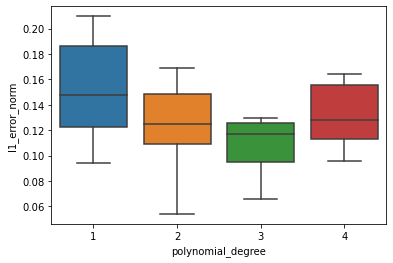

In [17]:
# Plot the results 
polynomial_degree_list = []
l1_error_norm_list = []

for r in sweep_degree_results:
    polynomial_degree_list.append(r['param']['deconvolution_params']['polynomial_degree'])
    l1_error_norm_list.append(r['error']['L1_error_norm'].item())
    
res_df = pd.DataFrame({'polynomial_degree': polynomial_degree_list,
                      'l1_error_norm': l1_error_norm_list})

sns.boxplot(x=res_df['polynomial_degree'], y=res_df['l1_error_norm'])